In [119]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

In [120]:
df = pd.read_csv("covtype.csv", sep=',')

c:\Users\aujo8\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 251'. Pick better value with 'binwidth'.


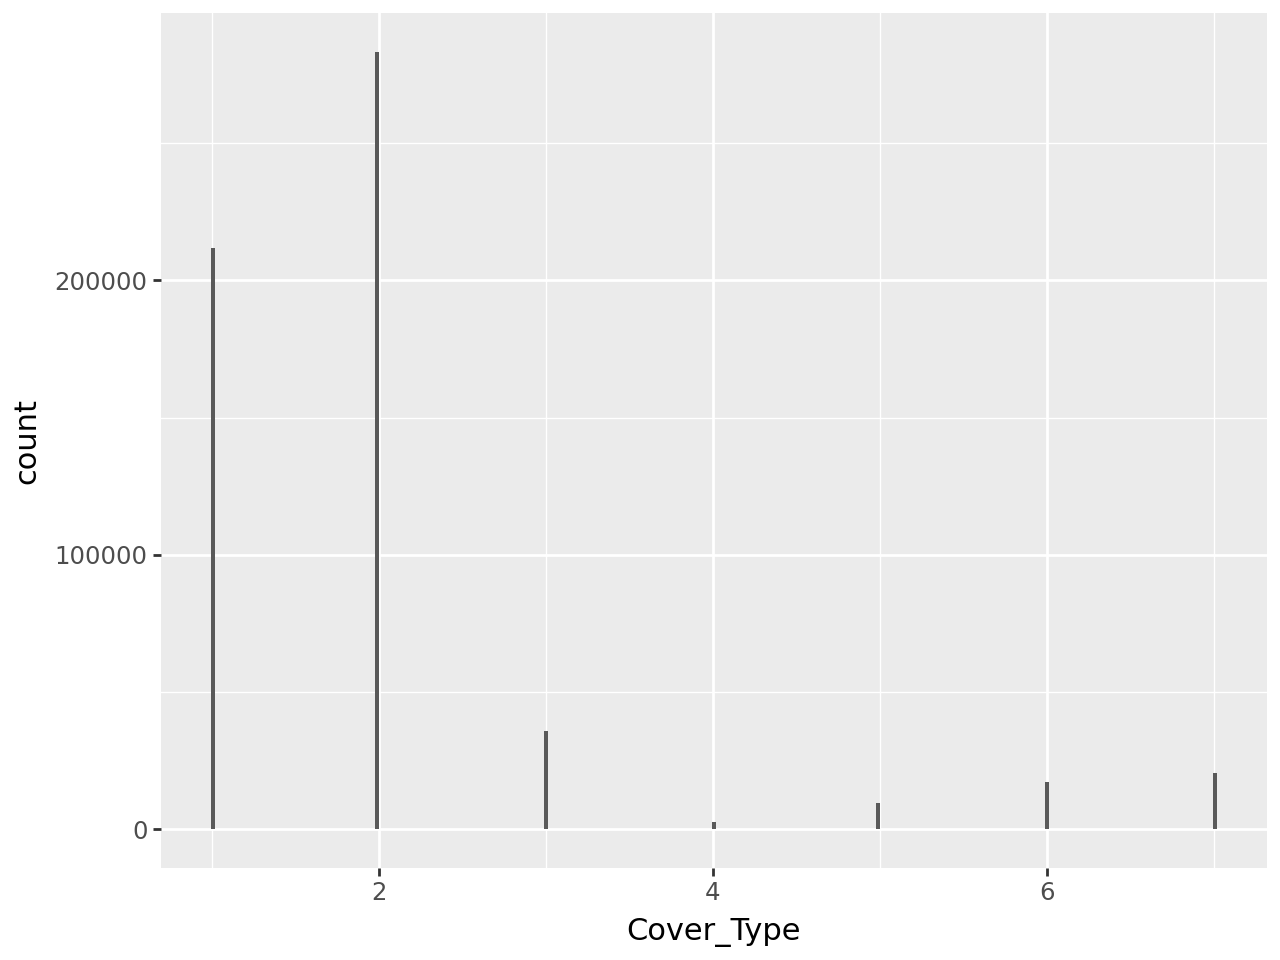

In [121]:
ggplot(df, aes(x="Cover_Type")) +\
    geom_histogram()

## Task 3

In [122]:
def standardize(data):
    m = np.mean(data, axis=0)
    s = np.std(data, axis=0)
    strd_data = (data - m)/s
    return strd_data

## Task 5

In [123]:
train, testval = train_test_split(df, test_size=0.2, random_state=1995)
test, val = train_test_split(testval, test_size=0.5, random_state=1995)

In [124]:
# standardizing the non-categorical features (the first ten features)
# also seperating the data into targets y and input features X
X_train = pd.concat([standardize(train.iloc[:, 0:10]), train.iloc[:, 10:-1]], axis=1)
# y_train = train["Cover_Type"]
y_train = pd.get_dummies(train["Cover_Type"], dtype=int)

X_test = pd.concat([standardize(test.iloc[:, 0:10]), test.iloc[:, 10:-1]], axis=1)
# y_test = test["Cover_Type"]
y_test = pd.get_dummies(test["Cover_Type"], dtype=int)

X_val = pd.concat([standardize(val.iloc[:, 0:10]), val.iloc[:, 10:-1]], axis=1)
# y_val = val["Cover_Type"]
y_val = pd.get_dummies(val["Cover_Type"], dtype=int)

## Task 6

In [125]:
import os
import torch
from torch.utils.data import DataLoader
from torch import nn

# if possible, running on GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "hip"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [126]:
# transforming our data into tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()

X_test_tensor = torch.tensor(X_test.values).float() 
y_test_tensor = torch.tensor(y_test.values).float()

X_val_tensor = torch.tensor(X_val.values).float()
y_val_tensor = torch.tensor(y_val.values).float()

In [127]:
# creating torch datasets in preparation for mini batches
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

# the dataloaders for the mini batches
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

In [133]:
# defining the neural net
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 70),
            nn.ReLU(),
            nn.Linear(70, 7)
            # nn.ReLU(),
            # nn.Linear(70, 60),
            # nn.ReLU(),
            # nn.Linear(60, 7)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
# instantiating the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=54, out_features=70, bias=True)
    (1): ReLU()
    (2): Linear(in_features=70, out_features=7, bias=True)
  )
)


In [134]:
learning_rate = 1e-3
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# per epoch losses
training_loss = []
validation_loss = []

# training/validation loop
for epoch in range(epochs):
    
    # training phase
    model.train()
    train_loss = 0.0
    print(f"Epoch {epoch+1}\n-------------------------------")
    for batch, (X, y) in enumerate(train_dl):
        # Move data to device
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dl)
    training_loss.append(avg_train_loss)
    print(f"Average training Loss: {avg_train_loss:.4f}")

    # validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dl)
    validation_loss.append(avg_val_loss)
    print(f"Average validation Loss: {avg_val_loss:.4f}\n")


print("Training complete!")

Epoch 1
-------------------------------
Average training Loss: 0.6021
Average validation Loss: 0.5431

Epoch 2
-------------------------------
Average training Loss: 0.5174
Average validation Loss: 0.5087

Epoch 3
-------------------------------
Average training Loss: 0.4886
Average validation Loss: 0.4794

Epoch 4
-------------------------------
Average training Loss: 0.4707
Average validation Loss: 0.4652

Epoch 5
-------------------------------
Average training Loss: 0.4577
Average validation Loss: 0.4547

Epoch 6
-------------------------------
Average training Loss: 0.4473
Average validation Loss: 0.4440

Epoch 7
-------------------------------
Average training Loss: 0.4393
Average validation Loss: 0.4398

Epoch 8
-------------------------------
Average training Loss: 0.4327
Average validation Loss: 0.4369

Epoch 9
-------------------------------
Average training Loss: 0.4265
Average validation Loss: 0.4265

Epoch 10
-------------------------------
Average training Loss: 0.4217
Av

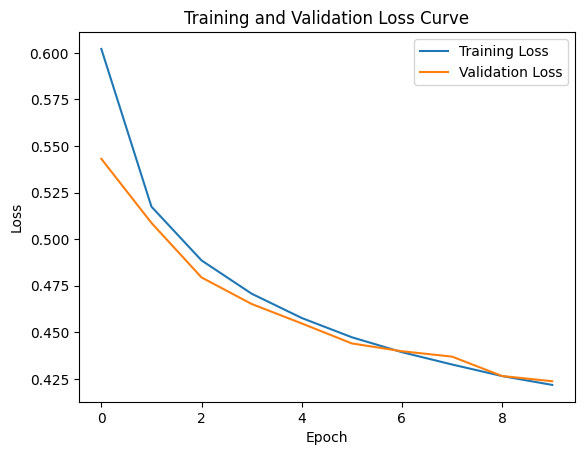

In [135]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curve")
plt.show()